### Experiment with Copia module: book genres
This notebook explores the data on the survival of poetic books (1834-1850) stored in 10 library collections; books are manually provided with general genre tags, the groups are:
- col_lyr: poetry collections of lyrical texts (short poems);
- col_nar: colletcions of narrative poems (~epic poetry);
- sep_lyr: separate issues of one lyrical text (one-two pages brochures with a single poem);
- sep_nar: separate issues of one narrative poem;
- sep_drama: separate issue of a dramatic text in verse;
- alm_ : almanacs and collective issues (may also include prose);

#### Part I: Tests for each book genre for the whole period (1834-1850)

In [1]:
import os
import glob

import matplotlib.pyplot as plt

import pandas as pd

import numpy as np
np.random.seed(1234)

In [2]:
import copia.utils as u
from copia.richness import *

from copia.utils import survival_ratio
from copia.utils import to_abundance, basic_stats

from copia.richness import species_accumulation

from copia.plot import abundance_histogram, accumulation_curve, multi_kde, survival_errorbar

In [3]:
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['ytick.minor.left'] = False

In [4]:
groups = {}
df = None

# import all separate .csv tables for the experiment as a dictionary of tables

for fh in sorted(glob.glob('../data/copia_experiment/*.csv')):
    df = pd.read_csv(fh)
    df = df.iloc[:,1:]
    genre = os.path.basename(fh).replace('.csv','').replace('_', ' ')
    groups[genre] = df[['work', 'collection']]

In [5]:
groups

{'Almanacks':                                                   work collection
 0    1834_43_Фл… Спин.._Незабудка: Московский Альма...        nlr
 1    1834_43_Фл… Спин.._Незабудка: Московский Альма...        rsl
 2    1834_43_Фл… Спин.._Незабудка: Московский Альма...      fi_sl
 3    1834_47_Максимович М._Денница: Альманах на 183...        nlr
 4    1834_47_Максимович М._Денница: Альманах на 183...      fi_sl
 ..                                                 ...        ...
 303  1830_981_NA_Чертополох, карманная книжица для ...        nlr
 304  1830_981_NA_Чертополох, карманная книжица для ...        rsl
 305  1830_981_NA_Чертополох, карманная книжица для ...      spbgu
 306  1830_1027_NA_Старинные диковинки, или собрание...        nlr
 307  1830_1027_NA_Старинные диковинки, или собрание...      fi_sl
 
 [308 rows x 2 columns],
 'Lyric booklets':                                                   work collection
 0    1834_27_Никонов В._Песнь русского : В 17 день ...        nlr
 1  

In [6]:
# Basic stats calculation

stats = []

for genre, df in groups.items():
    abundance = u.to_abundance(df['work']) # convert to abundance data
    s = u.basic_stats(abundance) # basic stats function
    d = {'Group': genre}
    # take f3 and f4 for well-survived groups
    for k in ('f1', 'f2', 'f3', 'f4', 'S', 'n'):
        d[k] = s[k]
    d['Collections'] = len(set(df['collection']))
    stats.append(d)
    
# Conversion to df for easier use
stats_df = pd.DataFrame(stats)
stats_df

,Group,f1,f2,f3,f4,S,n,Collections
0,Almanacks,6,26,41,16,101,308,9
1,Lyric booklets,188,56,15,8,269,387,11
2,Lyric collections,64,68,57,54,313,1000,11
3,Narrative booklets,69,72,60,31,257,659,11
4,Narrative collections,2,5,2,8,27,108,10


Almanacks
Lyric booklets
Lyric collections
Narrative booklets
Narrative collections


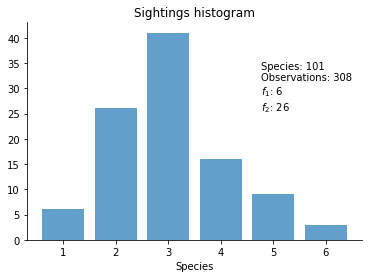

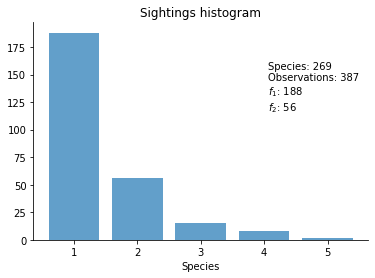

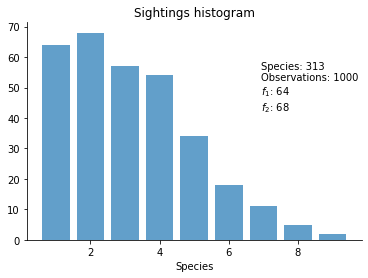

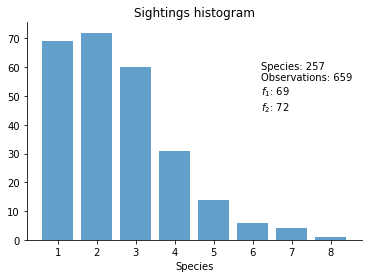

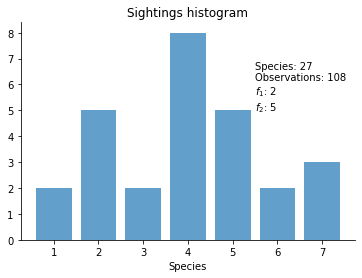

In [7]:
# fast viz: sightings histograms

for genre, df in groups.items():
    abundance = u.to_abundance(df['work'])
    print(genre)
    abundance_histogram(abundance)

In [8]:
# Estimations for original works with different estimators

estimation_dict = {}

for genre, df in groups.items():
    abundance = u.to_abundance(df['work'])
    estimation_dict[genre.title()] = abundance

for genre, population in estimation_dict.items():
    print('genre:', genre)
    for m in ('chao1', 'ichao1', 'egghe_proot'):
        print(' - ', m, '->', diversity(population, method = m))

genre: Almanacks
 -  chao1 -> 101.69005994005994
 -  ichao1 -> 101.69005994005994
 -  egghe_proot -> 101.02095891738362
genre: Lyric Booklets
 -  chao1 -> 583.7559985234404
 -  ichao1 -> 647.2716235234404
 -  egghe_proot -> 597.2595412883953
genre: Lyric Collections
 -  chao1 -> 343.0875294117647
 -  ichao1 -> 350.5057392883079
 -  egghe_proot -> 355.4937603040866
genre: Narrative Booklets
 -  chao1 -> 290.01232928679815
 -  ichao1 -> 290.01232928679815
 -  egghe_proot -> 293.4242222910879
genre: Narrative Collections
 -  chao1 -> 27.396296296296295
 -  ichao1 -> 27.482233796296295
 -  egghe_proot -> 27.19243329141031


In [9]:
# Minimum additional sample (lower bound on the true population size)

for genre, population in estimation_dict.items():
    print('genre:', genre)
    print(' - works : ', diversity(population, method = 'ichao1')) # ichao1 for taking into acc. f3 & f4
    print(' - documents : ', diversity(population, method = 'minsample'))

genre: Almanacks
 - works :  101.69005994005994
 - documents :  406.12889812889813
genre: Lyric Booklets
 - works :  647.2716235234404
 - documents :  6021.919134919135
genre: Lyric Collections
 - works :  350.5057392883079
 - documents :  3927.002927002927
genre: Narrative Booklets
 - works :  290.01232928679815
 - documents :  2654.915295915296
genre: Narrative Collections
 - works :  27.482233796296295
 - documents :  144.1908361908362


/Users/tonya/miniforge3/lib/python3.9/site-packages/copia/richness.py:424: RuntimeWarning: overflow encountered in exp
  v = lambda x: np.exp(x * (2 * f2 / f1))
/Users/tonya/miniforge3/lib/python3.9/site-packages/copia/richness.py:450: UserWarning: Tolerance criterion not met: 0.13672695360946818 > 0.1
  warnings.warn(f"Tolerance criterion not met: {diff_intersect} > {tolerance}")


In [10]:
# Survival ratios on density plot: works

works_survival = {}
for genre, population in estimation_dict.items():
    works_survival[genre] = survival_ratio(population, method = 'ichao1')

  0%|                                          | 1/1000 [00:01<19:29,  1.17s/it]/Users/tonya/miniforge3/lib/python3.9/site-packages/copia/richness.py:127: UserWarning: Add-one smoothing for f4 = 0
  warnings.warn("Add-one smoothing for f4 = 0", UserWarning)
100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 750.55it/s]


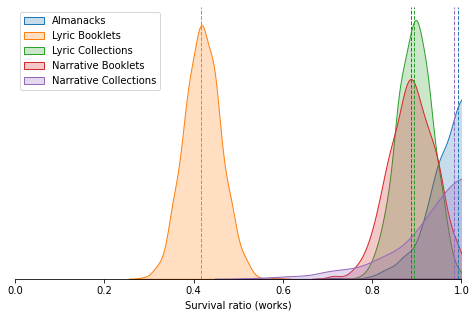

In [12]:
surv_density_works = multi_kde(works_survival)
surv_density_works.set_xlabel('Survival ratio (works)')
surv_density_works.set_yticklabels([])
surv_density_works.tick_params(axis = 'y', which = 'both', left = False)
surv_density_works.spines['left'].set_visible(False)

figure = plt.gcf() 
figure.set_size_inches(8, 5)
plt.savefig("../plots/Fig_4_Work_surv_density.jpeg", dpi = 300)

### Accumulation curves
- Lowest survival: 
    - Separate lyric poems
    - Separate narrative poems
    - Collections of lyric poems

100%|███████████████████████████████████████████| 10/10 [00:01<00:00,  5.30it/s]


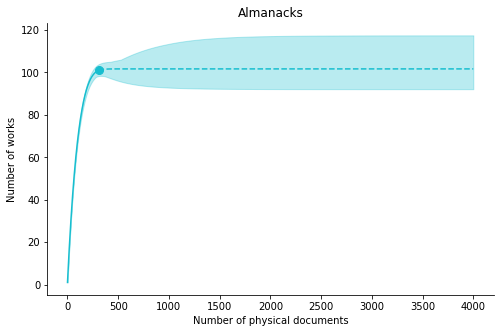

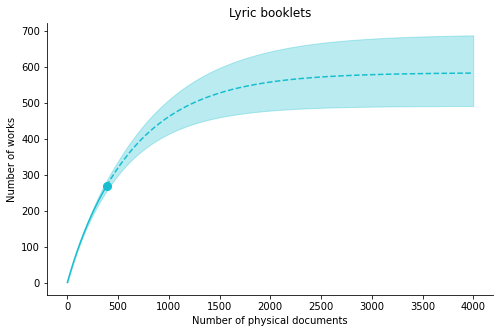

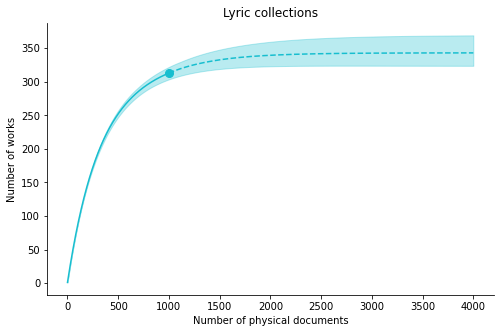

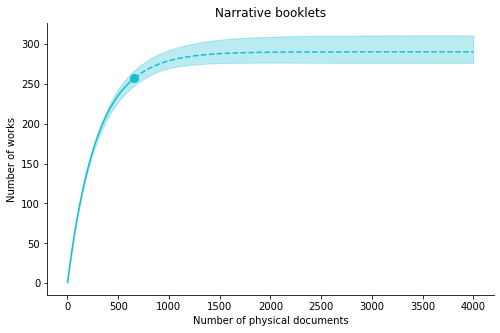

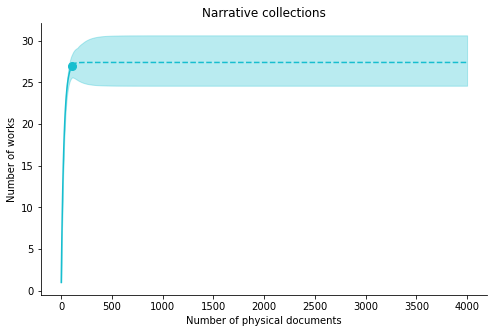

In [15]:
# accumulation curves

for genre, df in groups.items():
    abundance = u.to_abundance(df['work'])
    accumulation = species_accumulation(abundance, max_steps = 4000, n_iter = 10)
    accumulation_curve(abundance, accumulation, 
                       xlabel = 'Number of physical documents', ylabel = 'Number of works',
                       title = genre, 
                       c0 = 'C9')
    plt_name = '../plots/Fig_5_'+genre+'.jpeg'
    
    figure = plt.gcf() 
    figure.set_size_inches(8, 5)
    plt.savefig(plt_name, dpi = 300)

#### Comparison of different estimators (works)

In [48]:
comp = []

for estim in ['chao1', 'ichao1', 'egghe_proot']:
    for genre, population in estimation_dict.items():
        surv = survival_ratio(population, method = estim, n_iter = 1000)
        comp.append([genre, estim, surv['survival'], surv['lci'], surv['uci']])

  0%|                                          | 1/1000 [00:01<17:21,  1.04s/it]/Users/tonya/miniforge3/lib/python3.9/site-packages/copia/richness.py:127: UserWarning: Add-one smoothing for f4 = 0
  warnings.warn("Add-one smoothing for f4 = 0", UserWarning)
  0%|                                          | 1/1000 [00:01<17:35,  1.06s/it]/Users/tonya/miniforge3/lib/python3.9/site-packages/copia/richness.py:185: UserWarning: Add-one smoothing for P2 = 0
  warnings.warn("Add-one smoothing for P2 = 0", UserWarning)
100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 829.61it/s]


In [49]:
comp_df = pd.DataFrame(comp, columns = ['genre', 'estimator', 'survival_ratio', 'lower_ci', 'upper_ci'])

estimates = comp_df.sort_values(['genre', 'estimator'])
estimates

,genre,estimator,survival_ratio,lower_ci,upper_ci
0,Almanacks,chao1,0.993214,0.890111,1.087568
10,Almanacks,egghe_proot,0.999793,0.783059,1.153762
5,Almanacks,ichao1,0.993214,0.872300,1.100082
1,Collections Lyric,chao1,0.912304,0.844669,0.975587
11,Collections Lyric,egghe_proot,0.880466,0.759151,0.997006
6,Collections Lyric,ichao1,0.892995,0.818155,0.971618
2,Collections Narrative,chao1,0.985535,0.720515,1.165238
12,Collections Narrative,egghe_proot,0.992923,0.424558,1.497863
7,Collections Narrative,ichao1,0.982453,0.700513,1.196818
3,Separate Lyric,chao1,0.460809,0.380035,0.547307


### Fast test: time differences for genres

In [13]:
groups_t = {}
df_t = None

# import all separate .csv tables for the experiment as a dictionary of tables

for fh in sorted(glob.glob('../data/copia_experiment/addition/Separate Lyric*.csv')):
    df_t = pd.read_csv(fh)
    df_t = df_t.iloc[:,1:]
    genre = os.path.basename(fh).replace('.csv','').lower()
    groups_t[genre] = df_t[['work', 'collection']]

In [14]:
groups_t

{'separate lyric 1830':                                                   work collection
 0    27_Никонов В._Песнь русского : В 17 день апрел...        nlr
 1    28_Виноградов Н._Куплеты, петые на Чернышенско...        nlr
 2    29_NA_Стихи для польского, [на случай прибытия...        nlr
 3    31_Бакунин В._Воспоминания при взгляде на памя...        nlr
 4    31_Бакунин В._Воспоминания при взгляде на памя...        rsl
 ..                                                 ...        ...
 164  1057_Глинка С._На акт в Московской практическо...        nlr
 165  1058_Глинка С._Обед, данный в купеческом собра...        nlr
 166  1060_Колянковский А._Чувство литовцев на приез...        nlr
 167  1072_Фомин Н._Воспоминание о добродетельной жи...        nlr
 168  1072_Фомин Н._Воспоминание о добродетельной жи...      spbgu
 
 [169 rows x 2 columns],
 'separate lyric 1835':                                                  work collection
 0   88_Топчибашев М. Д._На памятник Императору Але...   

In [15]:
# Basic stats calculation

stats_t = []

for genre, df in groups_t.items():
    abundance = u.to_abundance(df['work']) # convert to abundance data
    s = u.basic_stats(abundance) # basic stats function
    d = {'group': genre}
    # take f3 and f4 for well-survived groups
    for k in ('f1', 'f2', 'f3', 'f4', 'S', 'n'):
        d[k] = s[k]
    d['lib'] = len(set(df['collection']))
    stats_t.append(d)
    
# Conversion to df for easier use
stats_t_df = pd.DataFrame(stats_t)
stats_t_df

,group,f1,f2,f3,f4,S,n,lib
0,separate lyric 1830,70,29,5,4,110,169,10
1,separate lyric 1835,25,9,4,1,39,59,7
2,separate lyric 1840,34,10,3,1,48,67,7
3,separate lyric 1845,59,8,3,2,72,92,6


In [18]:
populations_t = {}

for genre, df in groups_t.items():
    abundance = u.to_abundance(df_t['work'])
    populations_t[genre.title()] = abundance
    
wsurvival_t = {}

for genre, population in populations_t.items():
    wsurvival_t[genre] = survival_ratio(population, method = 'chao1')

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 831.04it/s]


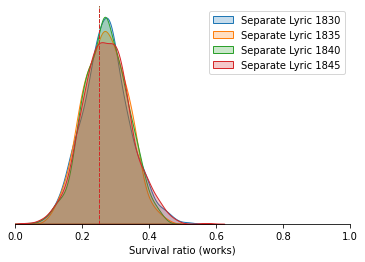

In [20]:
surv_density_w_t = multi_kde(wsurvival_t)
surv_density_w_t.set_xlabel('Survival ratio (works)')
surv_density_w_t.set_yticklabels([])
surv_density_w_t.tick_params(axis = 'y', which = 'both', left = False)
surv_density_w_t.spines['left'].set_visible(False)

plt.savefig("../plots/03_surv_density_periods_sl.jpeg", dpi = 300)


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 820.83it/s]

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 812.15it/s]

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 806.74it/s]

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 819.49it/s]


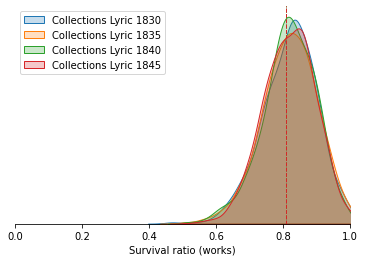

In [22]:
groups_t = {}
df_t = None

# import all separate .csv tables for the experiment as a dictionary of tables

for fh in sorted(glob.glob('../data/copia_experiment/addition/Collections Lyric*.csv')):
    df_t = pd.read_csv(fh)
    df_t = df_t.iloc[:,1:]
    genre = os.path.basename(fh).replace('.csv','').lower()
    groups_t[genre] = df_t[['work', 'collection']]
    
populations_t = {}

for genre, df in groups_t.items():
    abundance = u.to_abundance(df_t['work'])
    populations_t[genre.title()] = abundance
    
wsurvival_t = {}

for genre, population in populations_t.items():
    wsurvival_t[genre] = survival_ratio(population, method = 'chao1')

surv_density_w_t = multi_kde(wsurvival_t)
surv_density_w_t.set_xlabel('Survival ratio (works)')
surv_density_w_t.set_yticklabels([])
surv_density_w_t.tick_params(axis = 'y', which = 'both', left = False)
surv_density_w_t.spines['left'].set_visible(False)


plt.savefig("../plots/03_surv_density_periods_cl.jpeg", dpi = 300)